In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import datasets, transforms, models
from torch.autograd import Variable
from zipfile import ZipFile
import os
from os import path
import shutil

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
url = '/content/drive/MyDrive/'

In [4]:
dataset_A = url + 'dataset_2_image.zip'
with ZipFile(dataset_A, 'r') as zip:
  zip.extractall()

In [26]:
PATH = '/content/'
train_data_labels = pd.read_csv('/content/csv/updatetrain.csv', usecols = ['filename', 'digit'])
test_data_labels = pd.read_csv('/content/csv/updatetest.csv', usecols = ['filename', 'digit'])
train_data_labels.head()


,filename,digit
0,0.jpg,9
1,1.jpg,0
2,2.jpg,0
3,3.jpg,3
4,4.jpg,0


In [27]:
TRAIN_PATH = url + 'Train'
os.mkdir(TRAIN_PATH)

def processImages(folder_name):
  src = PATH + folder_name + '/'
  dir_folders = os.listdir(src)
  for dir_name in dir_folders:
    file_name = os.path.join(src, dir_name)
    if os.path.isfile(file_name):
      shutil.copy(file_name, TRAIN_PATH) 

processImages('training-a')

FileExistsError: ignored

In [28]:
class Dataset(Dataset):
    def __init__(self, df, root, transform=None):
        self.data = df
        self.root = root
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data.iloc[index]
        
        path = self.root + "/" + item[0]
        image = Image.open(path).convert('L')
        label = item[1]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

In [29]:
mean = [0.5,]
std = [0.5, ]

train_transform = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
        transforms.Resize(28),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
])

train_data  = Dataset(train_data_labels, '/content/train', train_transform)
test_data = Dataset(test_data_labels, '/content/test_28', test_transform)

print("Trainig Samples: ", len(train_data))

Trainig Samples:  60000


# **Base Parameters**

In [30]:
batch_size = 80
num_iters = 50000
input_dim = 28*28
num_hidden = 900
output_dim = 10

learning_rate = 0.05

num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

66


In [31]:
test_size = 0.2
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
train_idx, test_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler=test_sampler)

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))

Train dataloader:600
Test dataloader:150


In [32]:
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
       
        self.linear_1 = nn.Linear(input_size, num_hidden)
        self.relu_1 = nn.ReLU()
 
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        self.relu_2 = nn.ReLU()
 
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        self.relu_3 = nn.ReLU()
 
        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        self.relu_4 = nn.ReLU()
 
        self.linear_5= nn.Linear(num_hidden, num_hidden)
        self.relu_5= nn.ReLU()
 
        self.linear_6 = nn.Linear(num_hidden, num_hidden)
        self.relu_6 = nn.ReLU()
 
        self.linear_out = nn.Linear(num_hidden, num_classes)
 
    def forward(self, x):
        out  = self.linear_1(x)
        out = self.relu_1(out)
        
        out  = self.linear_2(out)
        out = self.relu_2(out)
 
        out  = self.linear_3(out)
        out = self.relu_3(out)
 
        out  = self.linear_4(out)
        out = self.relu_4(out)
 
        out  = self.linear_5(out)
        out = self.relu_5(out)
 
        out  = self.linear_6(out)
        out = self.relu_6(out)
        
        probas  = self.linear_out(out)
        return probas

In [33]:
model = DeepNeuralNetworkModel(input_size = input_dim, num_classes = output_dim, num_hidden = num_hidden)

model.to(device)

DeepNeuralNetworkModel(
  (linear_1): Linear(in_features=784, out_features=900, bias=True)
  (relu_1): ReLU()
  (linear_2): Linear(in_features=900, out_features=900, bias=True)
  (relu_2): ReLU()
  (linear_3): Linear(in_features=900, out_features=900, bias=True)
  (relu_3): ReLU()
  (linear_4): Linear(in_features=900, out_features=900, bias=True)
  (relu_4): ReLU()
  (linear_5): Linear(in_features=900, out_features=900, bias=True)
  (relu_5): ReLU()
  (linear_6): Linear(in_features=900, out_features=900, bias=True)
  (relu_6): ReLU()
  (linear_out): Linear(in_features=900, out_features=10, bias=True)
)

In [34]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

In [35]:
iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    print('Epoch: ', epoch + 1)
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images) 

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        iter += 1

        if iter % 500 == 0:        
            correct = 0
            total = 0
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                outputs = model(images)

                _, predicted = torch.max(outputs, 1)

                total += labels.size(0)

                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Epoch:  1
Iteration: 500. Loss: 0.8090744018554688. Accuracy: 61.95
Epoch:  2
Iteration: 1000. Loss: 0.6277232766151428. Accuracy: 80.50833333333334
Epoch:  3
Iteration: 1500. Loss: 0.3703173100948334. Accuracy: 82.00833333333334
Epoch:  4
Iteration: 2000. Loss: 0.4964316785335541. Accuracy: 84.125
Epoch:  5
Iteration: 2500. Loss: 0.4356776177883148. Accuracy: 84.23333333333333
Iteration: 3000. Loss: 0.3409222364425659. Accuracy: 85.16666666666667
Epoch:  6
Iteration: 3500. Loss: 0.37214967608451843. Accuracy: 87.01666666666667
Epoch:  7
Iteration: 4000. Loss: 0.23801258206367493. Accuracy: 87.36666666666666
Epoch:  8
Iteration: 4500. Loss: 0.4310153126716614. Accuracy: 87.925
Epoch:  9
Iteration: 5000. Loss: 0.25594884157180786. Accuracy: 88.26666666666667
Epoch:  10
Iteration: 5500. Loss: 0.2826750576496124. Accuracy: 87.05
Iteration: 6000. Loss: 0.44083738327026367. Accuracy: 88.375
Epoch:  11
Iteration: 6500. Loss: 0.34658724069595337. Accuracy: 87.10833333333333
Epoch:  12
Iterati

In [37]:
torch.save(model.state_dict(), '/content/drive/MyDrive/model_base.pkl')

[0.8090744018554688, 0.6277232766151428, 0.3703173100948334, 0.4964316785335541, 0.4356776177883148, 0.3409222364425659, 0.37214967608451843, 0.23801258206367493, 0.4310153126716614, 0.25594884157180786, 0.2826750576496124, 0.44083738327026367, 0.34658724069595337, 0.4045453667640686, 0.22185106575489044, 0.2097775638103485, 0.2538130581378937, 0.1414676308631897, 0.3135850727558136, 0.10307189077138901, 0.1391279399394989, 0.28796276450157166, 0.13588310778141022, 0.27904844284057617, 0.2072221338748932, 0.1624961644411087, 0.15768475830554962, 0.1719941794872284, 0.08866596221923828, 0.06962786614894867, 0.26418381929397583, 0.11904831230640411, 0.055255185812711716, 0.12151868641376495, 0.09969951212406158, 0.09853799641132355, 0.11989568173885345, 0.06288705766201019, 0.08941160142421722, 0.08737999200820923, 0.1317654252052307, 0.038627348840236664, 0.0501704216003418, 0.20083971321582794, 0.019977934658527374, 0.09965181350708008, 0.07316906750202179, 0.06317780166864395, 0.14829

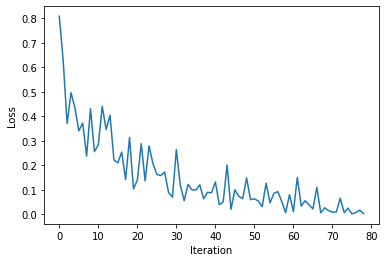

In [36]:
print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.show()